In [1]:
#CC
#https://krasserm.github.io/2018/03/21/bayesian-optimization/
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm


%matplotlib inline

bounds = np.array([[-2.0, 3.0]])
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
# Dense grid of points within bounds
X_init = np.array([[-0.9], [1.1]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

Y_init = f(X_init)

# Noise-free objective function values at X 
Y = f(X,0)

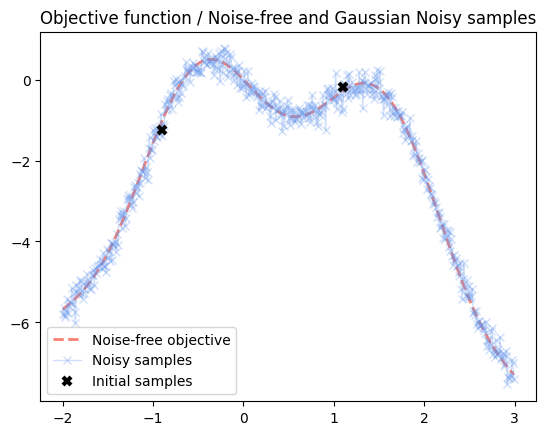

In [2]:
# Plot optimization objective with noise level 
plt.plot(X, Y, color = 'salmon', linestyle = "--", lw=2, label='Noise-free objective')
plt.plot(X, f(X), color = 'cornflowerblue', marker = "x", lw=1, alpha=0.3, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.title("Objective function / Noise-free and Gaussian Noisy samples", fontsize = 12)
plt.legend();


In [3]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the Exptected Improvement (EI) at the domain points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements (EI) of domain points X.
    '''
    #Gaussian process of whole domain X
    mu, sigma = gpr.predict(X, return_std=True)
    #Gaussian process of sample domain X
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)    
    # Needed for noise-based model, otherwise one can use np.max(Y_sample)
    mu_sample_opt = np.max(mu_sample)

    #calculating EI 
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        #using the cumulative distribution function (CDF) and probability density function (PDF) of a normal distribution
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        for i, value in enumerate(sigma[:]):
            if value == 0:
                ei[i] = 0
    return ei


In [4]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        #quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno (BFGS). It uses the first derivatives only.
        # L-BFGS-B uses the L-BFGS-B algorithm for bound constrained minimization.
        #ref.: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            #print(res.fun)
            min_val = res.fun
            min_x = res.x           
            
    return min_x.reshape(-1, 1)


In [5]:
#CC to https://github.com/pradeepsinngh/Bayesian-Optimization/blob/master/bayesian_optimization_util.py
#which enables a plotting schematic of bayesian optimization very comfortable

def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, color = 'cornflowerblue', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, color = 'salmon', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, color = "salmon")
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, color = 'cornfloerblue')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

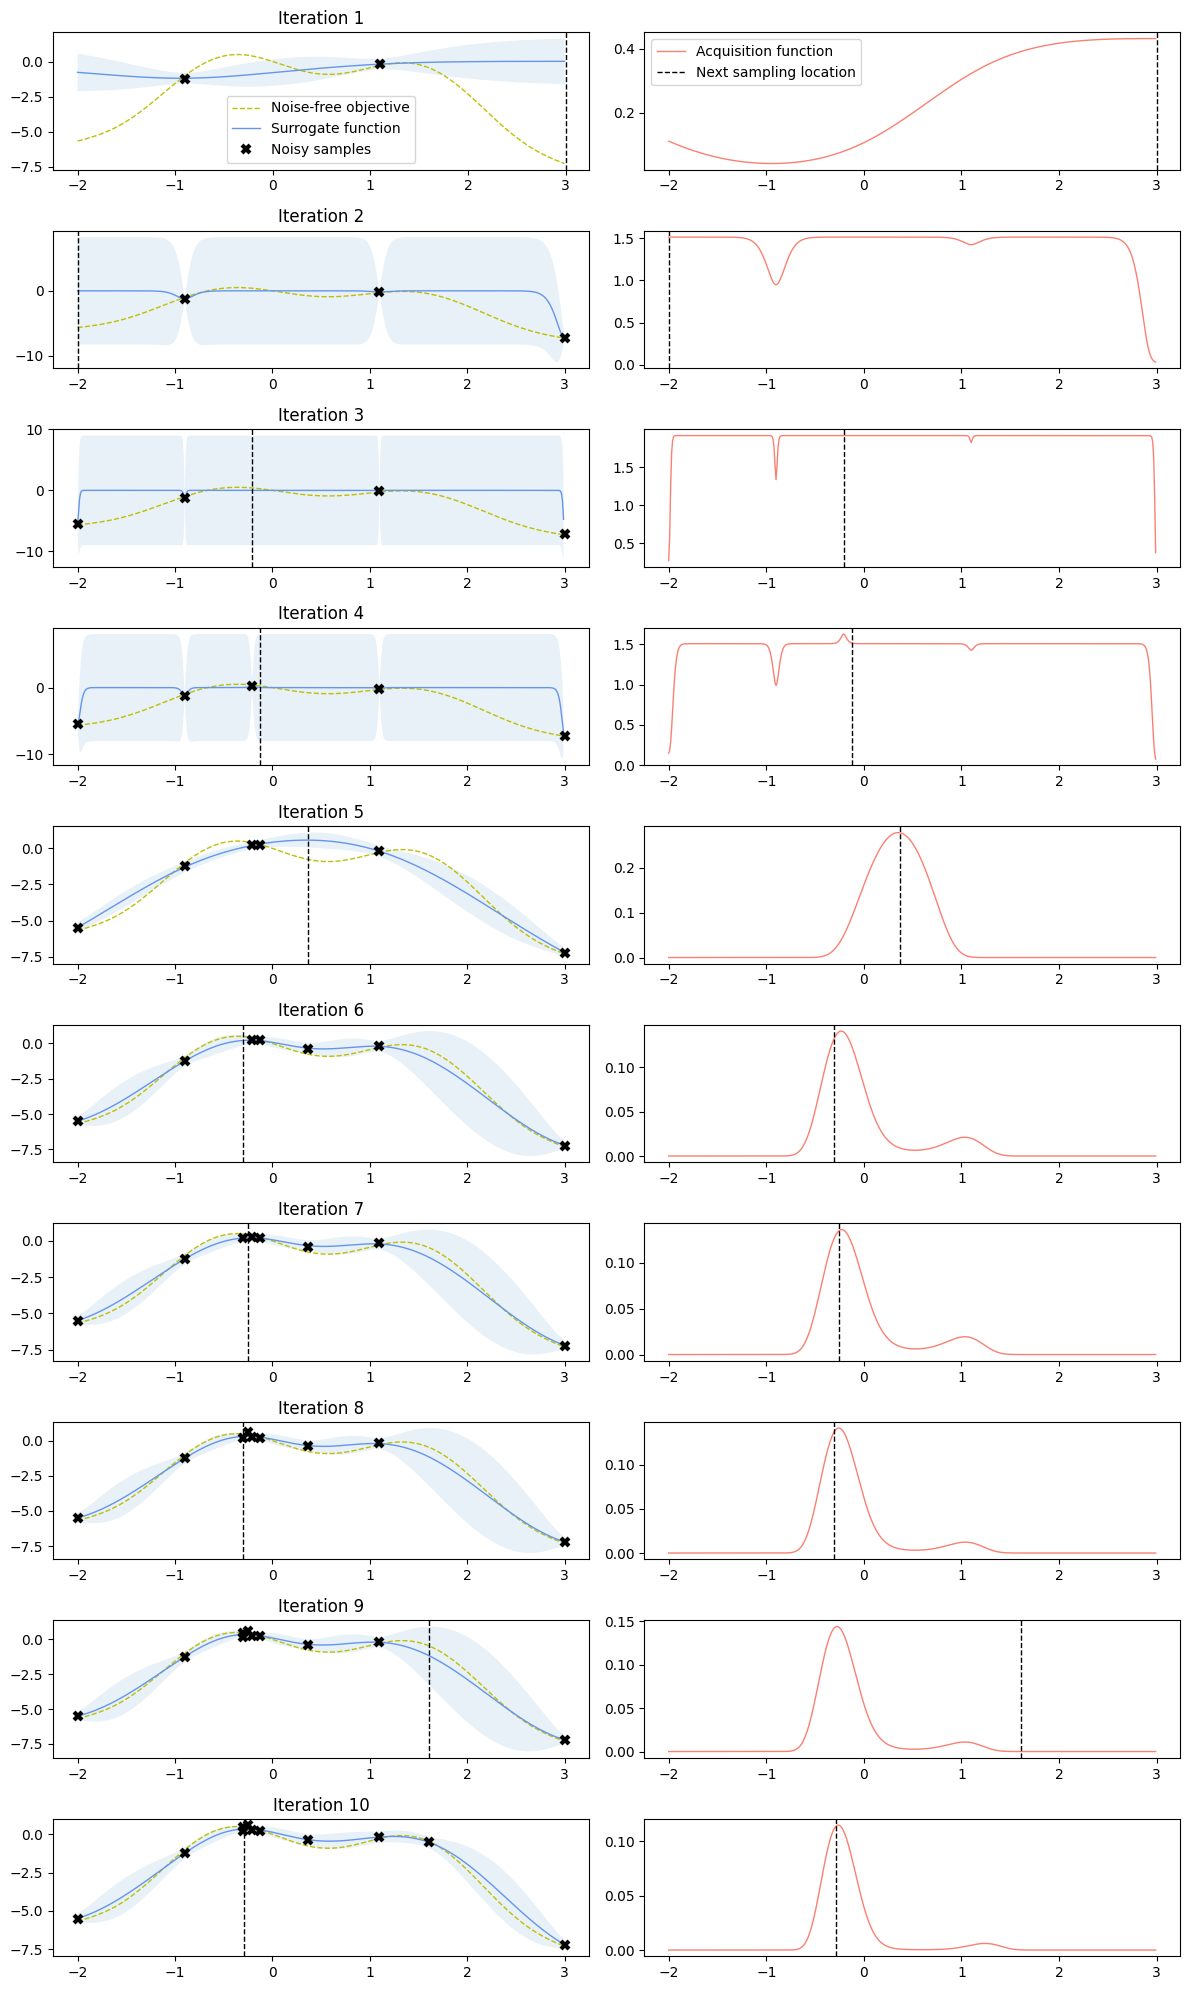

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 2))
#fig=plt.figure()
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement) = (EI)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}', fontsize = 12)

    #calculating current expected improvement for plotting
    ei_ = expected_improvement(X, X_sample, Y_sample, gpr)[:][-10]

    #plotting acquisition function
    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, ei_, X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

#fig.suptitle(f"Bayesian optimization of scalar objetive function $F(x)$ over {n_iter} iterations with Gaussian Prior")
plt.tight_layout()
plt.savefig("bayesian_optimization_from_scratch_iterations.png", dpi = 300)

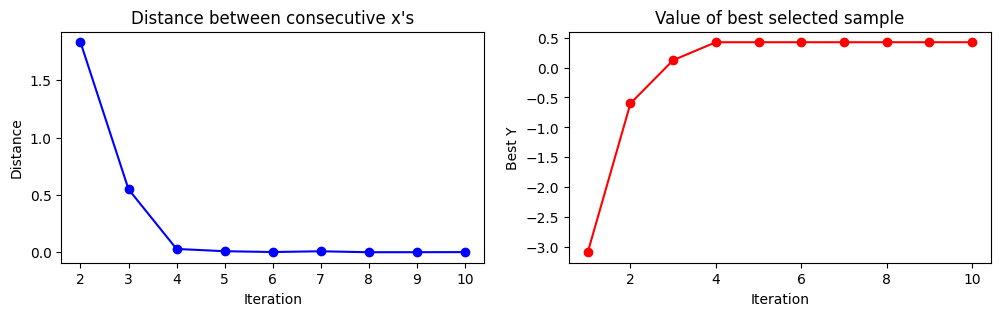

In [21]:
plot_convergence(X_sample, Y_sample)